# MNIST data setup #
We will use the classic MNIST dataset, which consists of black-and-white images of hand-drawn digits (between 0 and 9).

We will use pathlib for dealing with paths (part of the Python 3 standard library), and will download the dataset using requests. We will only import modules when we use them, so you can see exactly what’s being used at each point.

In [24]:
from pathlib import Path
import requests
import matplotlib.pyplot as plt
import numpy as np
import torch
import math

In [25]:
DATA_PATH = Path("data")
PATH = (DATA_PATH / "mnist")
PATH.mkdir(exist_ok=True, parents=True)
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

In [26]:

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

This dataset is in numpy array format, and has been stored using pickle, a python-specific format for serializing data.

In [27]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let’s take a look at one; we need to reshape it to 2d first.

In [28]:
(classes, frequency ) = np.unique(y_train, return_counts=True);
classes, frequency

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([4932, 5678, 4968, 5101, 4859, 4506, 4951, 5175, 4842, 4988]))

## Dataset visualization ##

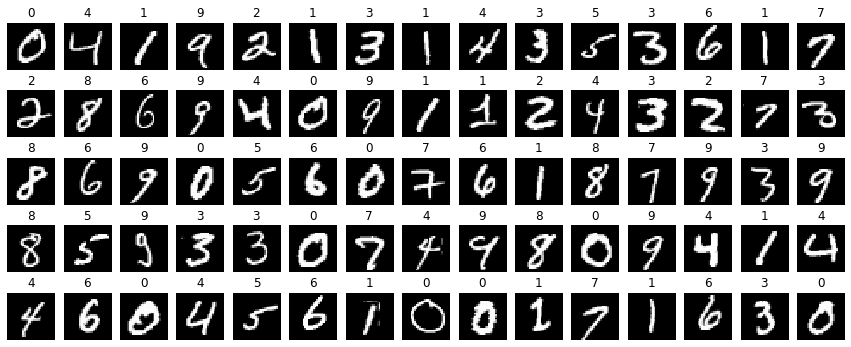

In [29]:
rows = 5
cols = 15
index = 1
plt.figure(figsize=(cols, rows+1))
for i in range(rows):
    for j in range(cols):
        plt.subplot(rows, cols, index)
        plt.imshow(x_train[index].reshape(28,28), cmap='gray')
        plt.title(str(y_train[index]))
        plt.axis(False)
        index +=1


In [30]:
def histogram_plot(cls  = None, inp= None, Train= True):
    # Plotting the histogram of the classes
    (classes, frequency ) = np.unique(inp, return_counts=True);
    plt.figure(figsize= (5, 3))
    plt.stem(frequency, use_line_collection= True)
    plt.grid('both')
    if Train:
        plt.title('Frequency of Numbers in the Train')
    else:
        plt.title('Frequency of Numbers in the Validation')
    plt.xlabel('Number')
    plt.ylabel('Frequency')
    plt.axis(True)
    plt.show()

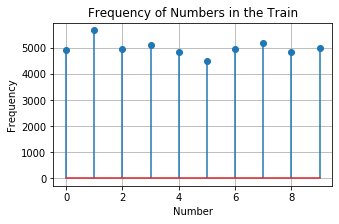

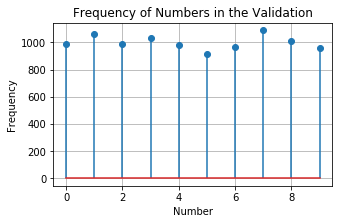

In [31]:
histogram_plot(cls=10, inp=y_train, Train=True )
histogram_plot(cls=10, inp=y_valid, Train=False)

## Convert the numpy data to Torch tensors #

In [32]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, 
                                         (x_train, y_train, x_valid, y_valid))


## Neural Network Using `nn.Module` ##
Next up, we’ll use `nn.Module` and `nn.Parameter`, for a clearer and more concise training loop. We subclass `nn.Module` (which itself is a class and able to keep track of state). In this case, we want to create a class that holds our weights, bias, and method for the forward step. `nn.Module` has a number of attributes and methods (such as `.parameters()` and `.zero_grad()`) which we will be using.



In [33]:
from torch import nn

## Defining the  `model()` ##
Thanks to PyTorch’s ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model! So let’s just write a plain matrix multiplication and broadcasted addition to create a simple linear model. We also need an activation function, so we’ll write `log_softmax` and use it. Remember: although PyTorch provides lots of pre-written loss functions, activation functions, and so forth, you can easily write your own using plain python. PyTorch will even create fast GPU or vectorized CPU code for your function automatically.

In [34]:
# n, c  = x_train.shape
class MNIST_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
#         self.weights = nn.Parameter(torch.randn(784, 10)/math.sqrt(784))
#         self.bias = nn.Parameter(torch.zeros(10))
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)
model = MNIST_Logistic()

In [35]:
import torch.nn.functional as F
loss_func = F.cross_entropy

In [36]:
bs = 64
xb = x_train[0:bs]
yb = y_train[0:bs]

In [37]:
loss_func(model(xb), yb)

tensor(2.2577, grad_fn=<NllLossBackward>)

In [38]:
# Calculating the accuracy of the model
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

In [39]:
print((accuracy(model(xb), yb)*100).item(),'%')

9.375 %


# Training Loop #

- select a mini-batch of data (of size bs)
- use the model to make predictions
- calculate the loss
- `loss.backward()` updates the gradients of the model, in this case, weights and bias.
Previously for our training loop we had to update the values for each parameter by name, and manually zero out the grads for each parameter separately, like this:
    
```python
  with torch.no_grad():
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()
```
   
Now we can take advantage of `model.parameters()` and `model.zero_grad()` (which are both defined by PyTorch for `nn.Module`) to make those steps more concise and less prone to the error of forgetting some of our parameters, particularly if we had a more complicated model:
```python 
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

In [40]:
# Printing the loass and accuracy of the model before we start Training #
print('Loss: ', loss_func(model(xb), yb).item(), 'Accuracy: ', accuracy(model(xb), yb).item())

Loss:  2.25767183303833 Accuracy:  0.09375


In [41]:
print('Loss: ', loss_func(model(xb), yb).item(), 'Accuracy: ', accuracy(model(xb), yb).item())

Loss:  2.25767183303833 Accuracy:  0.09375


# Refactor using `optim`#
Pytorch also has a package with various optimization algorithms, `torch.optim`. We can use the step method from our optimizer to take a forward step, instead of manually updating each parameter.

This will let us replace our previous manually coded optimization step:
```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```
and instead we will write this:

```python
opt.step()
opt.zero_grad()
```

(`optim.zero_grad()` resets the gradient to 0 and we need to call it before computing the gradient for the next minibatch.)

In [42]:
from torch import optim

In [43]:
lr = 0.5
epochs = 5
n, c = x_train.shape
def get_model():
    model = MNIST_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr, momentum=0., dampening=0., weight_decay=0.)

In [44]:
model, opt = get_model()

In [45]:
print(model, opt)
print('Loss:', loss_func(model(xb), yb).item(), '    Accuracy:', accuracy(model(xb), yb).item())

MNIST_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
) SGD (
Parameter Group 0
    dampening: 0.0
    lr: 0.5
    momentum: 0.0
    nesterov: False
    weight_decay: 0.0
)
Loss: 2.280402183532715     Accuracy: 0.171875


# Refactor using DataLoader# 
Pytorch’s `DataLoader` is responsible for managing batches. You can create a `DataLoader` from any Dataset. DataLoader makes it easier to iterate over batches. Rather than having to use `train_ds[i*bs : i*bs+bs]`, the DataLoader gives us each minibatch automatically.
```python
from torch.utils.data import DataLoader
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)
```
Previously, our loop iterated over batches (xb, yb) like this:
```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)
```
Now, our loop is much cleaner, as (xb, yb) are loaded automatically from the data loader:
```python
for xb,yb in train_dl:
    pred = model(xb)
```

# Adding a validation set #

In section 1, we were just trying to get a reasonable training loop set up for use on our training data. In reality, you always should also have a validation set, in order to identify if you are overfitting.

Shuffling the training data is important to prevent correlation between batches and overfitting. On the other hand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We’ll use a batch size for the validation set that is twice as large as that for the training set. This is because the validation set does not need backpropagation and thus takes less memory (it doesn’t need to store the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.

```python
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
```
We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [46]:
"""
model, opt = get_model()
for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        preds = model(xb)
        loss = loss_func(preds, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
    
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
    
    print('Epoch:', epoch, 'Valid Loss:', valid_loss/len(valid_dl))
"""

"\nmodel, opt = get_model()\nfor epoch in range(epochs):\n    model.train()\n    for xb, yb in train_dl:\n        preds = model(xb)\n        loss = loss_func(preds, yb)\n\n        loss.backward()\n        opt.step()\n        opt.zero_grad()\n    \n    model.eval()\n    with torch.no_grad():\n        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)\n    \n    print('Epoch:', epoch, 'Valid Loss:', valid_loss/len(valid_dl))\n"

# Create `fit()` and `get_data()` #
We’ll now do a little refactoring of our own. Since we go through a similar process twice of calculating the loss for both the training set and the validation set, let’s make that into its own function, `loss_batch`, which computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform backprop. For the validation set, we don’t pass an optimizer, so the method doesn’t perform backprop.

In [47]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)
    

In [48]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt )
        
        model.eval()
        with torch.no_grad():
            losses, num = zip(
            *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
        valid_loss = np.sum(np.multiply(losses, num))/np.sum(num)
        
        print('Epoch:', epoch, 'Valid Loss:', valid_loss)

In [49]:
from torch.utils.data import TensorDataset, DataLoader
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

def get_data(train_ds, valid_ds, bs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(valid_ds, batch_size=bs*2),)


In [50]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(10, model, loss_func, opt, train_dl, valid_dl)

Epoch: 0 Valid Loss: 0.2926610855102539
Epoch: 1 Valid Loss: 0.3398929573893547
Epoch: 2 Valid Loss: 0.30945849972963335
Epoch: 3 Valid Loss: 0.3054017536878586
Epoch: 4 Valid Loss: 0.285254806137085
Epoch: 5 Valid Loss: 0.31924039565324785
Epoch: 6 Valid Loss: 0.2742871301174164
Epoch: 7 Valid Loss: 0.2709313517451286
Epoch: 8 Valid Loss: 0.27974238815307617
Epoch: 9 Valid Loss: 0.2802404939174652


The above three lines of code can be used to train a variety of models with specified optimizers and loss functions accordingly. 